In [1]:

import os
import gc
import numpy as np  
import scanpy as sc
import pandas as pd

from conformalSC_annotator import  ConformalSCAnnotator
from torchcp.classification.score import  APS


query_data_path = 'test_data/GSE178360/GSE178360_epi.h5ad'
#query_data_path = 'test_data/pancreas/pancreas_human_query_HV.h5ad'
adata_query = sc.read_h5ad(query_data_path) 

## This is te expected input data: ##

X = adata_query.X.astype(np.float32)                        # data matrix (cells x genes)
var_query_list = adata_query.var["features"].tolist()       # This is the case of the list
#var_query_df = pd.DataFrame({'features':var_query_list })  # Unncomment for testing. This is the case of the df
obs_query = adata_query.obs                                 # not needed, for ground thruth test

     


/home/mlopezdecas/paper_3/single_cell_annotator/conformalSC_annotator.py:499: SyntaxWarning: invalid escape sequence '\G'
  query_data_path = 'test_data\GSE178360\GSE178360_immune.h5ad'
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


annotator = ConformalSCAnnotator(X, var_query_list, obs_query) # obs_query is optional, it will be used for annotate the predicted cells. 

annotator.quality_control()  ## This is an optional step to do a basic preprocess the data. If the data is already preprocessed, this step is optional.

# Define que network architecture   
network_architecture:dict = {   
            "hidden_sizes": [128, 128, 64, 64],
            "dropout_rates": [0.4, 0.3, 0.4, 0.25],
            "learning_rate": 0.0001}

OOD_detector_config = {
            "alpha": 0.1,
            "delta": 0.1}
    

reference_data_path = os.path.join("models", "HumanLung_TopMarkersFC_level3.h5ad")     # Path to the reference data
#reference_data_path = 'test_data/pancreas/pancreas_reference_HV.h5ad'

annotator.configure(reference_path = reference_data_path,
                    model_architecture = network_architecture,   # Optional, if not provided, default values will be used
                    OOD_detector = OOD_detector_config,          # Optional, if not provided, default values will be used
                    CP_predictor = "cluster",                    # mondrian or cluster
                    cell_type_level = "celltype_level3",         # class name for fitting the model.  cell_type or celltype_level3 
                    cell_types_excluded_treshold = 50,           # Exclude cell types with less than 50 cells
                    test = True,                                 # Perform internal test of the model
                    alpha = [0.01, 0.05, 0.1],                   # Confidence of the predictions
                    non_conformity_function = APS(),             # NC-function provided by or compatible with torchCP    
                    epoch=40,
                    batch_size = 425)  
    

# annotate your data to a given significance level
annotator.annotate(batch_correction="harmony")  # batch_correction = "combat" or "harmony" or "mnn" or False



Succesfully generated object:  (7160, 30555)
Filtering low quality cells...
Filtered! Post-QC shape:  (7160, 30555)
Model not trained yet. Fitting the model first.
Loading reference data...
Reference data loaded.
Detecting common genes...
Common genes detected: 1140
Running integration....


2025-01-29 08:53:01,420 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-29 08:53:17,291 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-29 08:53:18,464 - harmonypy - INFO - Iteration 1 of 10
2025-01-29 08:54:59,880 - harmonypy - INFO - Iteration 2 of 10
2025-01-29 08:56:42,658 - harmonypy - INFO - Converged after 2 iterations


check integration: 
Data integrated!

Label distribution:
celltype_level3
AM                        95610
AT2                       56383
iMON                      17253
CAP1                      14696
Suprabasal                11162
AT1                       10137
Ciliated                   9629
NK                         8686
Basal                      7635
CAP2                       6985
IM                         5888
CD4_T                      5515
AF1                        4844
VEC                        4514
SVEC                       4269
RAS                        3999
AEC                        3974
Serous                     3329
LEC                        3281
CD8_T                      3170
B                          3069
Mast/Basophil              2798
Secretory                  2602
cDC2                       2510
AF2                        2502
VSMC                       2470
Pericyte                   2415
Plasma                     2104
pMON                       198

In [3]:
# Get the predictions returning the observations of the query data object
print("\nPredicted annotations sets: \n" , annotator.adata_query.obs)

    
ground_truth_labels_list = obs_query["cell_type"].tolist()
annotator.recover_original_cells( ground_truth_labels_list, similarity_threshold=70)


y_true = annotator._mapped_original_ground_truth_labels ## Ground thruth labels mapped to the model labels (predictions)
#annotator._mapping


results = []
for pred,cp_pred_001,cp_pred_005, cp_pred_010, true, o_g_t in zip(
        annotator.adata_query.obs["predicted_labels"],
        annotator.adata_query.obs["prediction_sets_0.01"],
        annotator.adata_query.obs["prediction_sets_0.05"],
        annotator.adata_query.obs["prediction_sets_0.1"],
        y_true,
         ground_truth_labels_list):
        
    print(f"Predicted: {pred} - CP 0.01: {cp_pred_001} - CP 0.05: {cp_pred_005} - CP 0.10: {cp_pred_010} - True: {true}. original cell Subt: {o_g_t}")
        
    results.append({
        "Predicted": pred,
        "CP 0.01": cp_pred_001,
        "CP 0.05": cp_pred_005,
        "CP 0.1": cp_pred_010,
        "True": true,
        "Original_Cell_Subtype": o_g_t
    })
    
df_results = pd.DataFrame(results)
df_results.to_csv("saves/results_immune.csv", index=False)  # Save to CSV if needed


Predicted annotations sets: 
                                orig.ident    nCount_RNA  nFeature_RNA  \
GCCCGAAAGTTGAAGT-1_1-query  SeuratProject  17076.681262          4325   
TGCTTCGGTCGAATGG-1_1-query  SeuratProject   7796.007873          2267   
AACAACCGTAGGAAAG-1_2-query  SeuratProject  25592.340370          5625   
GCCAGGTGTTTAAGGA-1_2-query  SeuratProject  22623.364808          4754   
GGGTCACTCTCCTGAC-1_2-query  SeuratProject   7983.031586          2538   
...                                   ...           ...           ...   
CACACAAGTGGGATTG-1_3-query  SeuratProject  10221.101179          1705   
ACGGGTCTCATTCCTA-1_3-query  SeuratProject   6013.438687          1431   
ATTCCATCAACTCGAT-1_3-query  SeuratProject   9248.591886           973   
GCAGGCTTCCGAAGGA-1_3-query  SeuratProject   4457.351034          1459   
GGATCTATCCCTTGTG-1_3-query  SeuratProject   8830.155078          1436   

                            nCount_SCT  nFeature_SCT  S.Score  G2M.Score  \
GCCCGAAAGTTGAAGT

In [4]:
df_results.head(10)

,Predicted,CP 0.01,CP 0.05,CP 0.1,True,Original_Cell_Subtype
0,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1+
1,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-
2,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-
3,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1+
4,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-
5,RAS,[RAS],[RAS],[],OOD,SFTPB+ SCGB3A2+ SCGB1A1+
6,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-
7,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-
8,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-
9,RAS,[RAS],[RAS],[RAS],OOD,SFTPB+ SCGB3A2+ SCGB1A1-


In [5]:
df_results['Original_Cell_Subtype'].value_counts()

Original_Cell_Subtype
Ciliated                    2410
SFTPB+ SCGB3A2+ SCGB1A1+    1130
SFTPB+ SCGB3A2+ SCGB1A1-     576
SFTPB- KRT5+ Basal           562
SFTPB+ KRT5_low Basal        442
MUC5AC+ MUC5B+               356
AT2                          327
SFTPC+ SCGB3A2+              287
AT1                          275
FOXJ1+ Secretory             239
SFTPB+ KRT5- Basal           122
Immature AT1                 102
Differentiating Basal         88
MUC5B+                        72
Proliferating                 64
Deuterosomal                  62
Proliferating AT2             35
Neuroendocrine                11
Name: count, dtype: int64

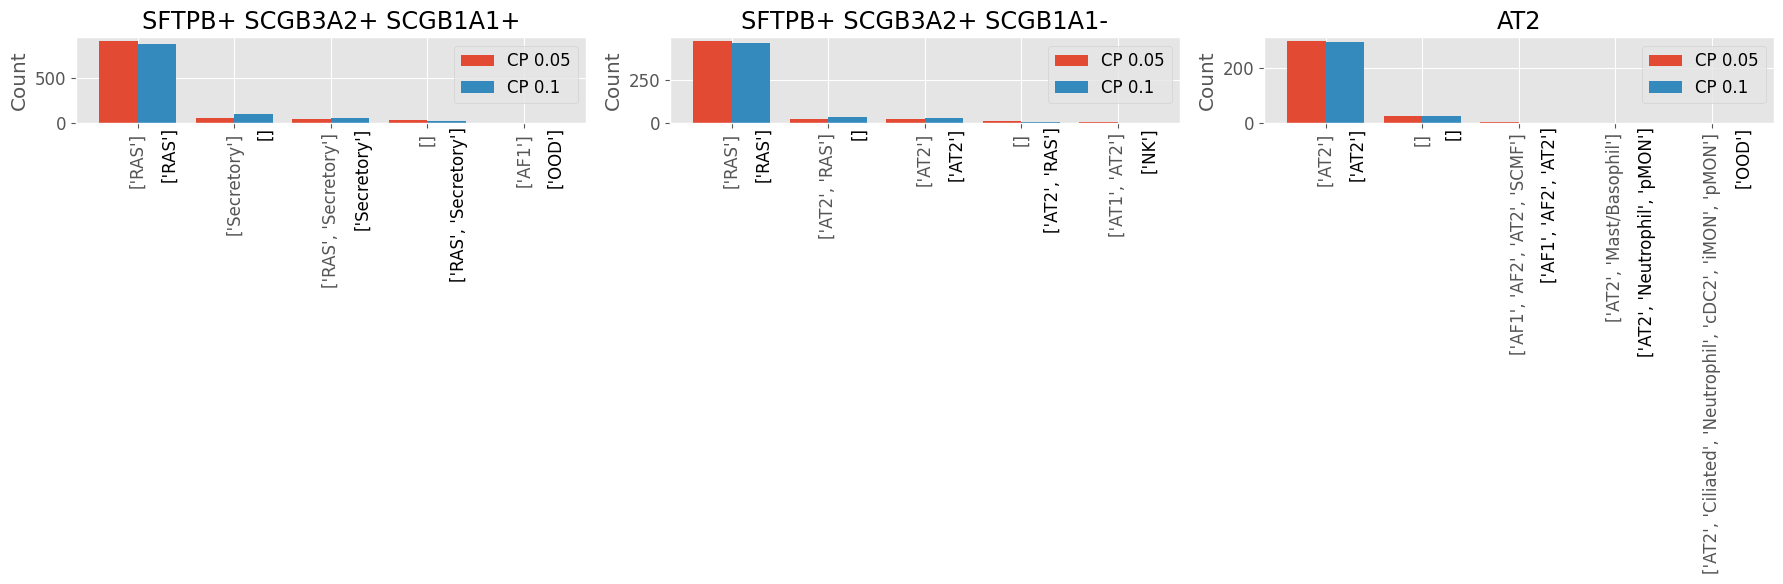

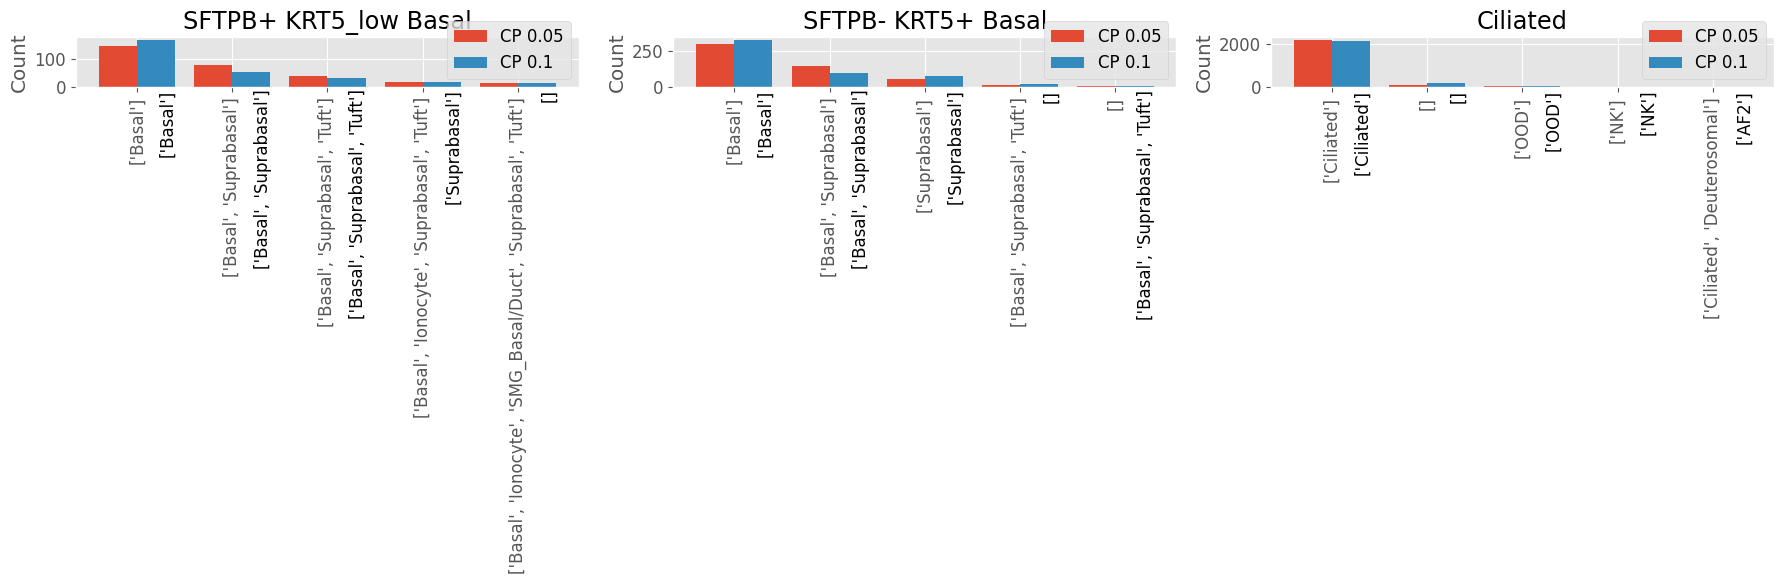

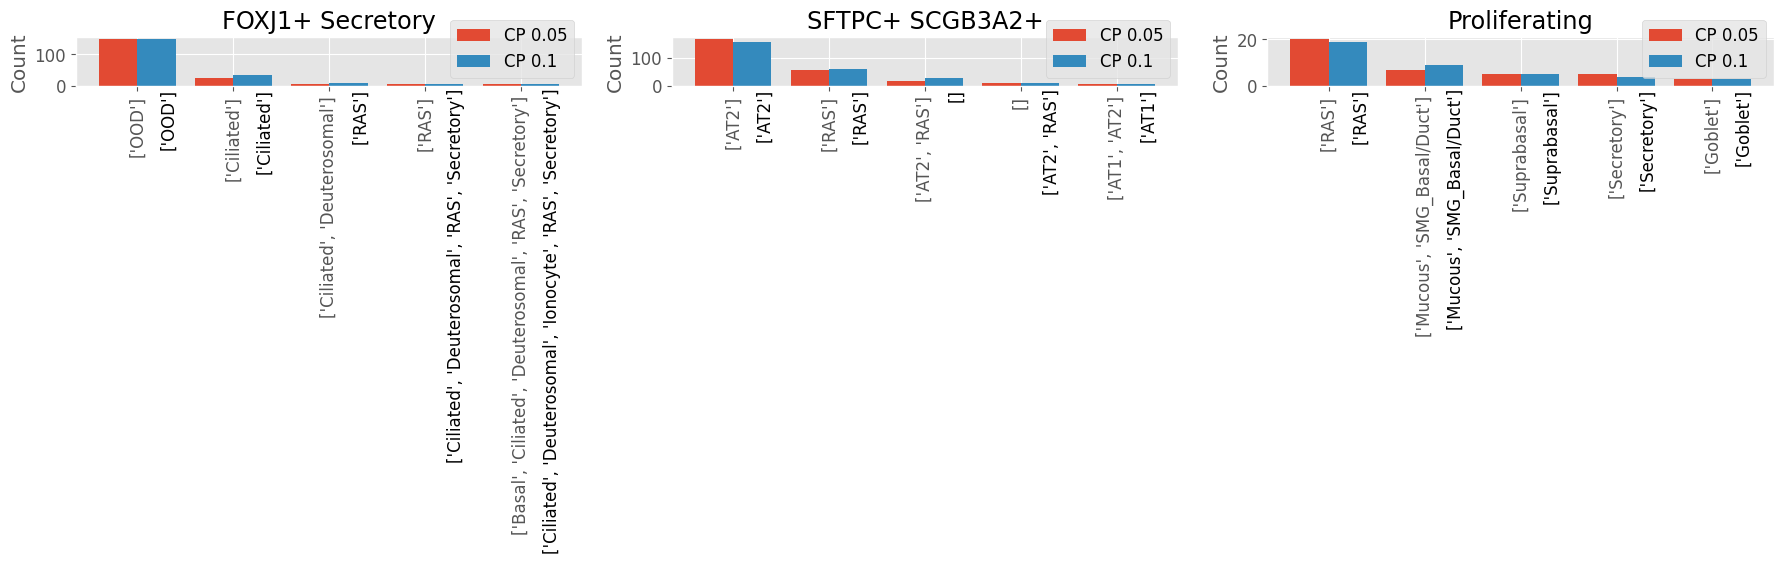

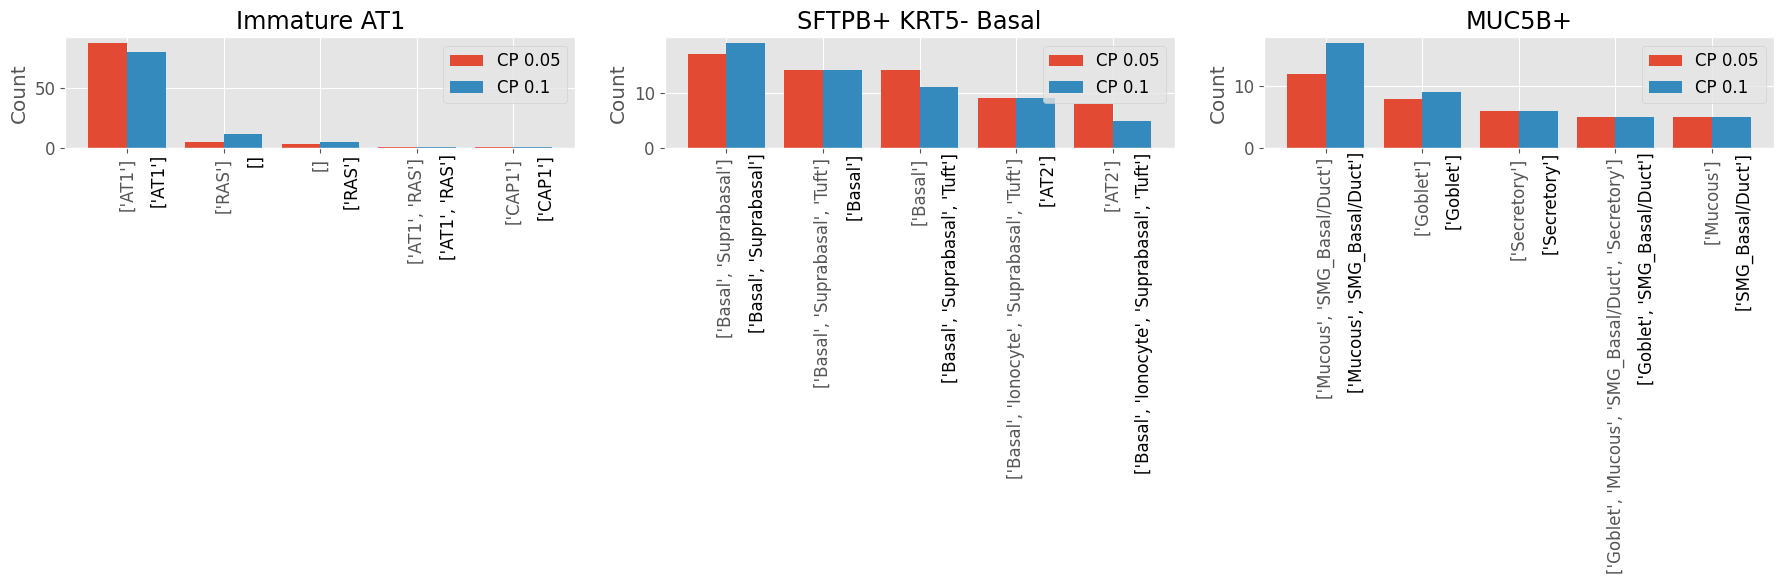

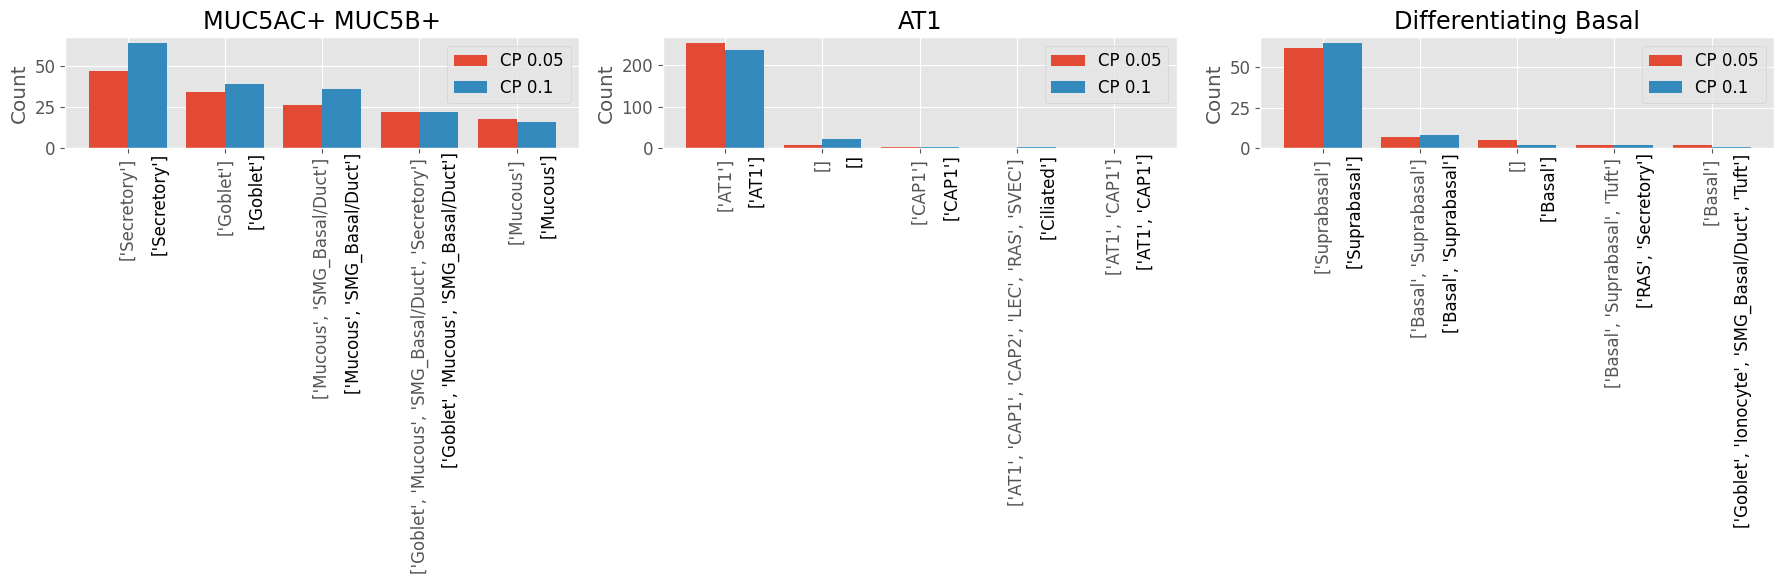

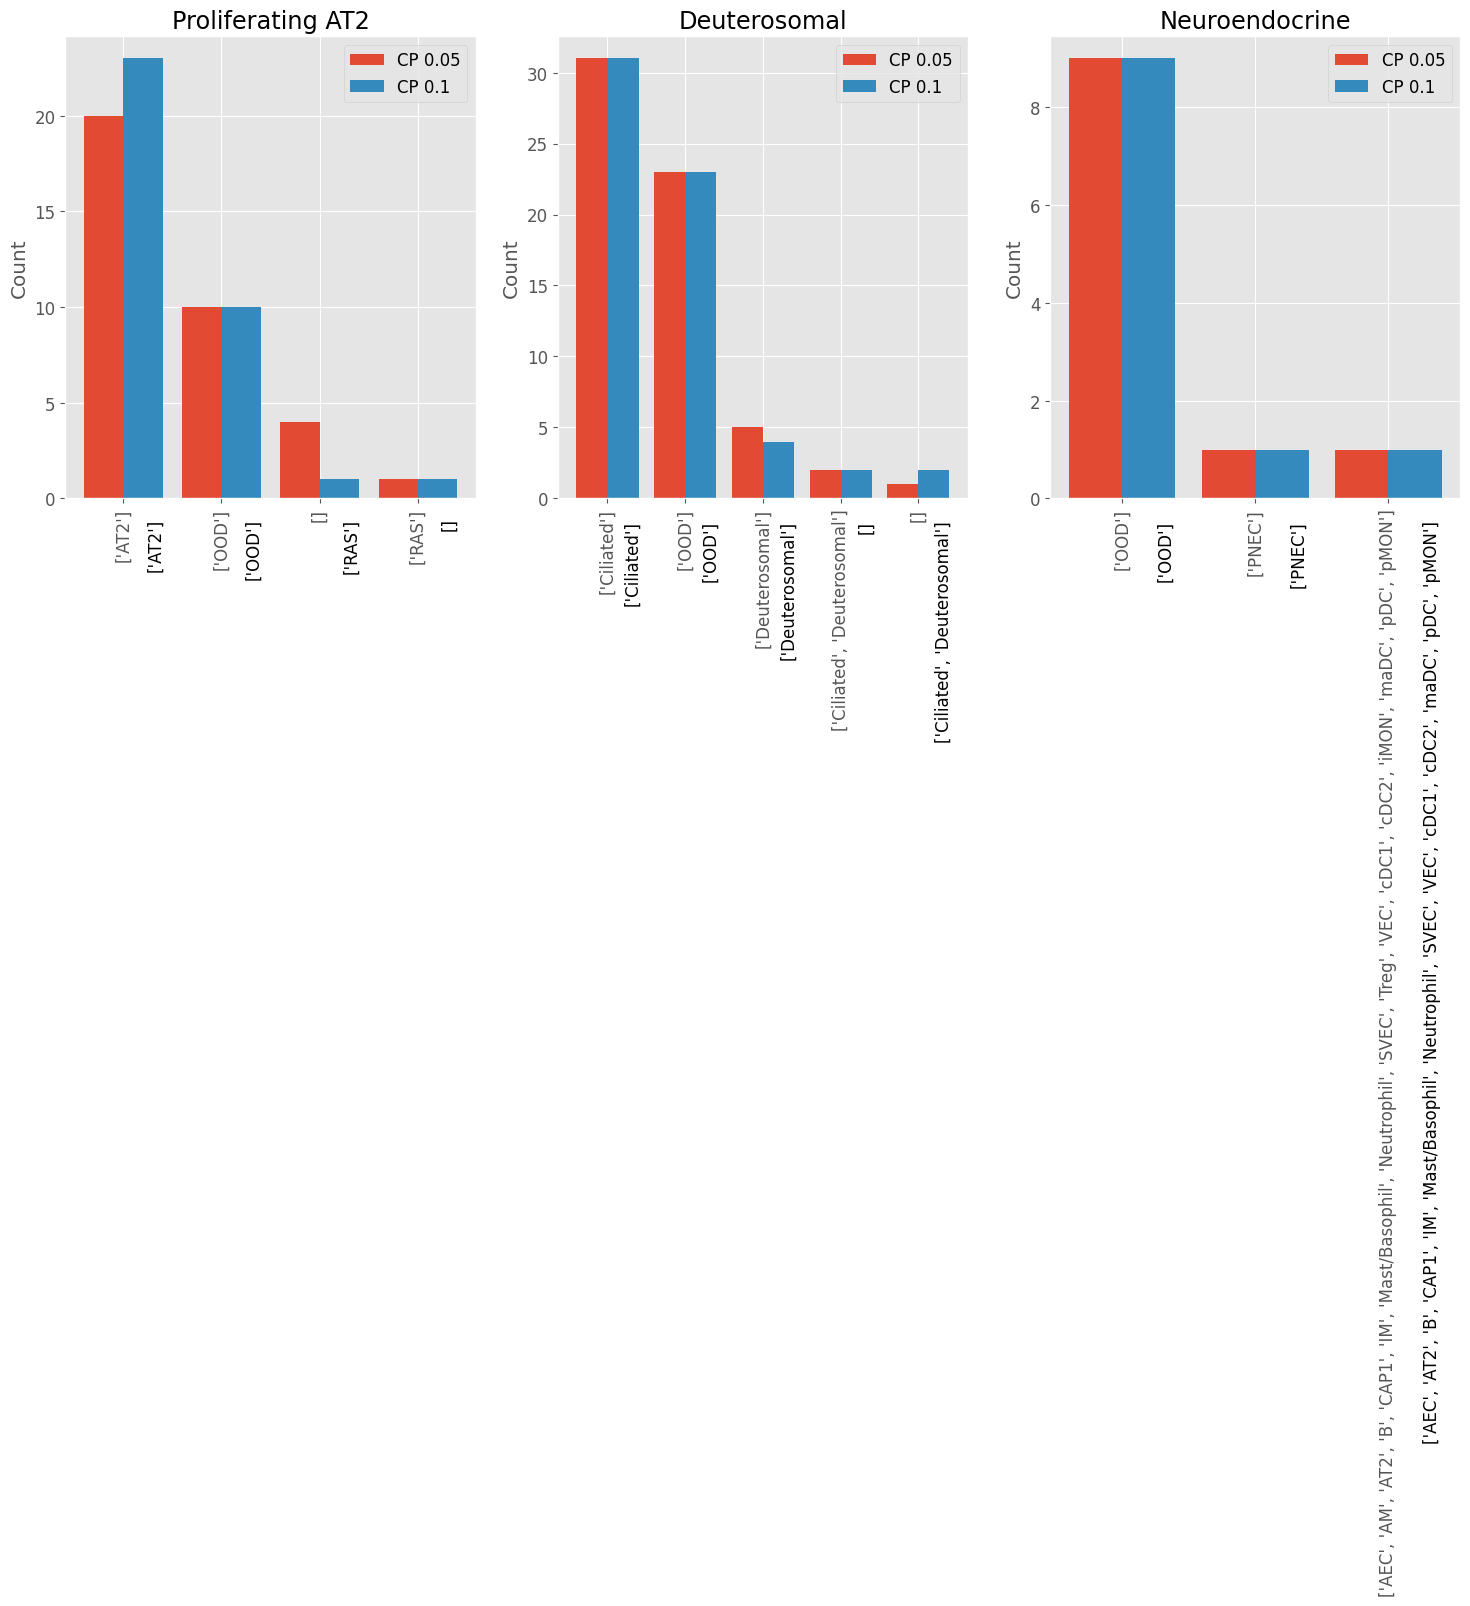

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set a scientific style for the plots
plt.style.use('ggplot')
rcParams.update({'font.size': 12, 'figure.figsize': (18, 6)})

unique_cells = df_results['Original_Cell_Subtype'].unique()

# Create blocks of 3
block_size = 3
for i in range(0, len(unique_cells), block_size):
    fig, axes = plt.subplots(1, block_size, figsize=(18, 6))
    for j, cell in enumerate(unique_cells[i:i + block_size]):
        ax = axes[j] if block_size > 1 else axes
        df_ = df_results[df_results['Original_Cell_Subtype'] == cell]

        try:
            # Get the top 5 value counts for both columns
            value_counts_05 = df_["CP 0.05"].astype(str).value_counts().head(5)
            value_counts_1 = df_["CP 0.1"].astype(str).value_counts().head(5)

            value_counts_05_names = value_counts_05.index
            value_counts_1_names = value_counts_1.index


            # Create the bar width and positions
            x = np.arange(len(value_counts_05))
            bar_width = 0.4

            # Plot the bars for CP 0.05 and CP 0.1
            bars_05 = ax.bar(x - bar_width / 2, value_counts_05, bar_width, label='CP 0.05')
        
            bars_1 = ax.bar(x + bar_width / 2, value_counts_1, bar_width, label='CP 0.1')
        
        except ValueError as e:

            long = min(len(df_["CP 0.05"].astype(str).value_counts().index), len(df_["CP 0.1"].astype(str).value_counts().index))
            value_counts_05 = df_["CP 0.05"].astype(str).value_counts().head(long)
            value_counts_1 = df_["CP 0.1"].astype(str).value_counts().head(long)

            value_counts_05_names = value_counts_05.index
            value_counts_1_names = value_counts_1.index


            # Create the bar width and positions
            x = np.arange(len(value_counts_05))
            bar_width = 0.4

            # Plot the bars for CP 0.05 and CP 0.1
            bars_05 = ax.bar(x - bar_width / 2, value_counts_05, bar_width, label='CP 0.05')
        
            bars_1 = ax.bar(x + bar_width / 2, value_counts_1, bar_width, label='CP 0.1')
        

        # Add labels, title, and legend
        ax.set_title(cell)
        ax.set_ylabel('Count')
        
        ax.set_xticks(x)
        ax.set_xticklabels(value_counts_05_names, rotation=90)
        # Add a second set of labels for CP 0.1 below the bars
        for bar, label in zip(bars_1, value_counts_1.index):
            ax.text(bar.get_x() + (bar.get_width() + 0.25 )/ 2, -max(value_counts_05) * 0.05, 
                    label, ha='center', va='top', rotation=90)
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()





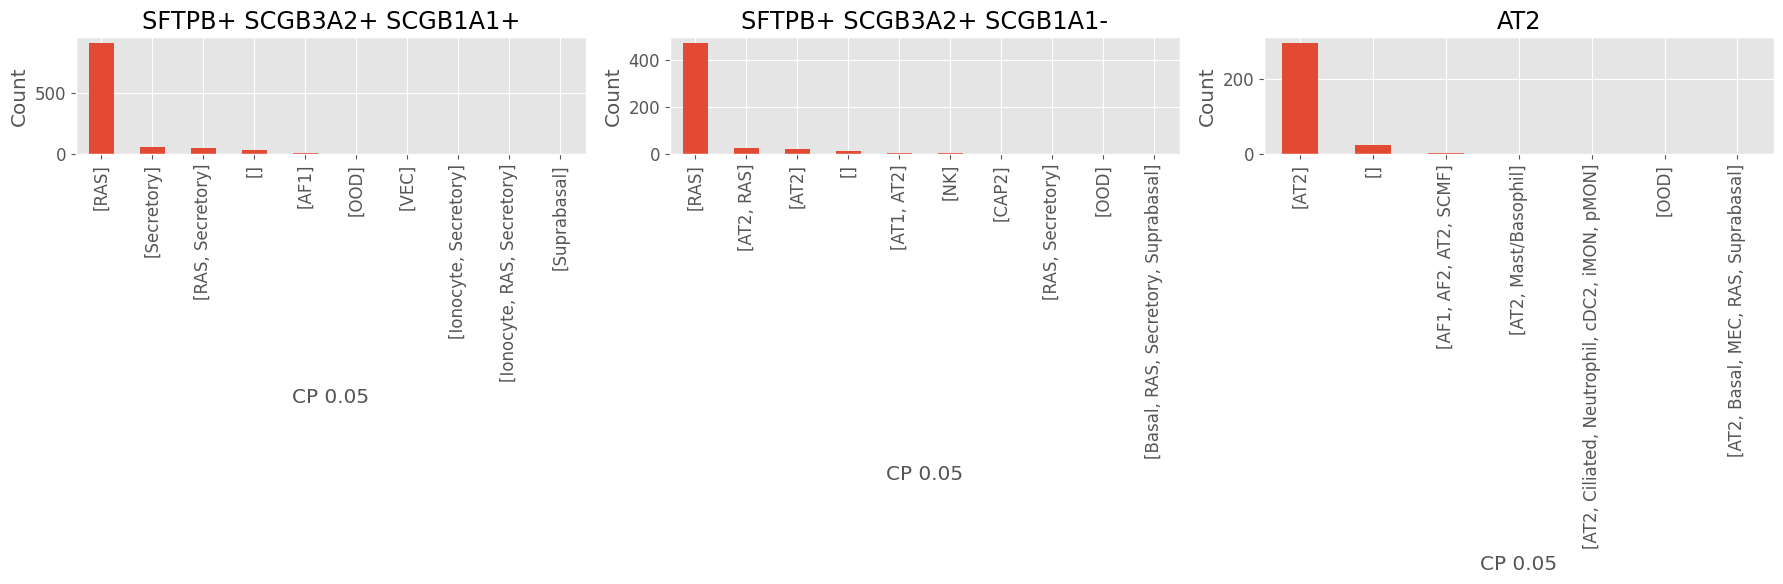

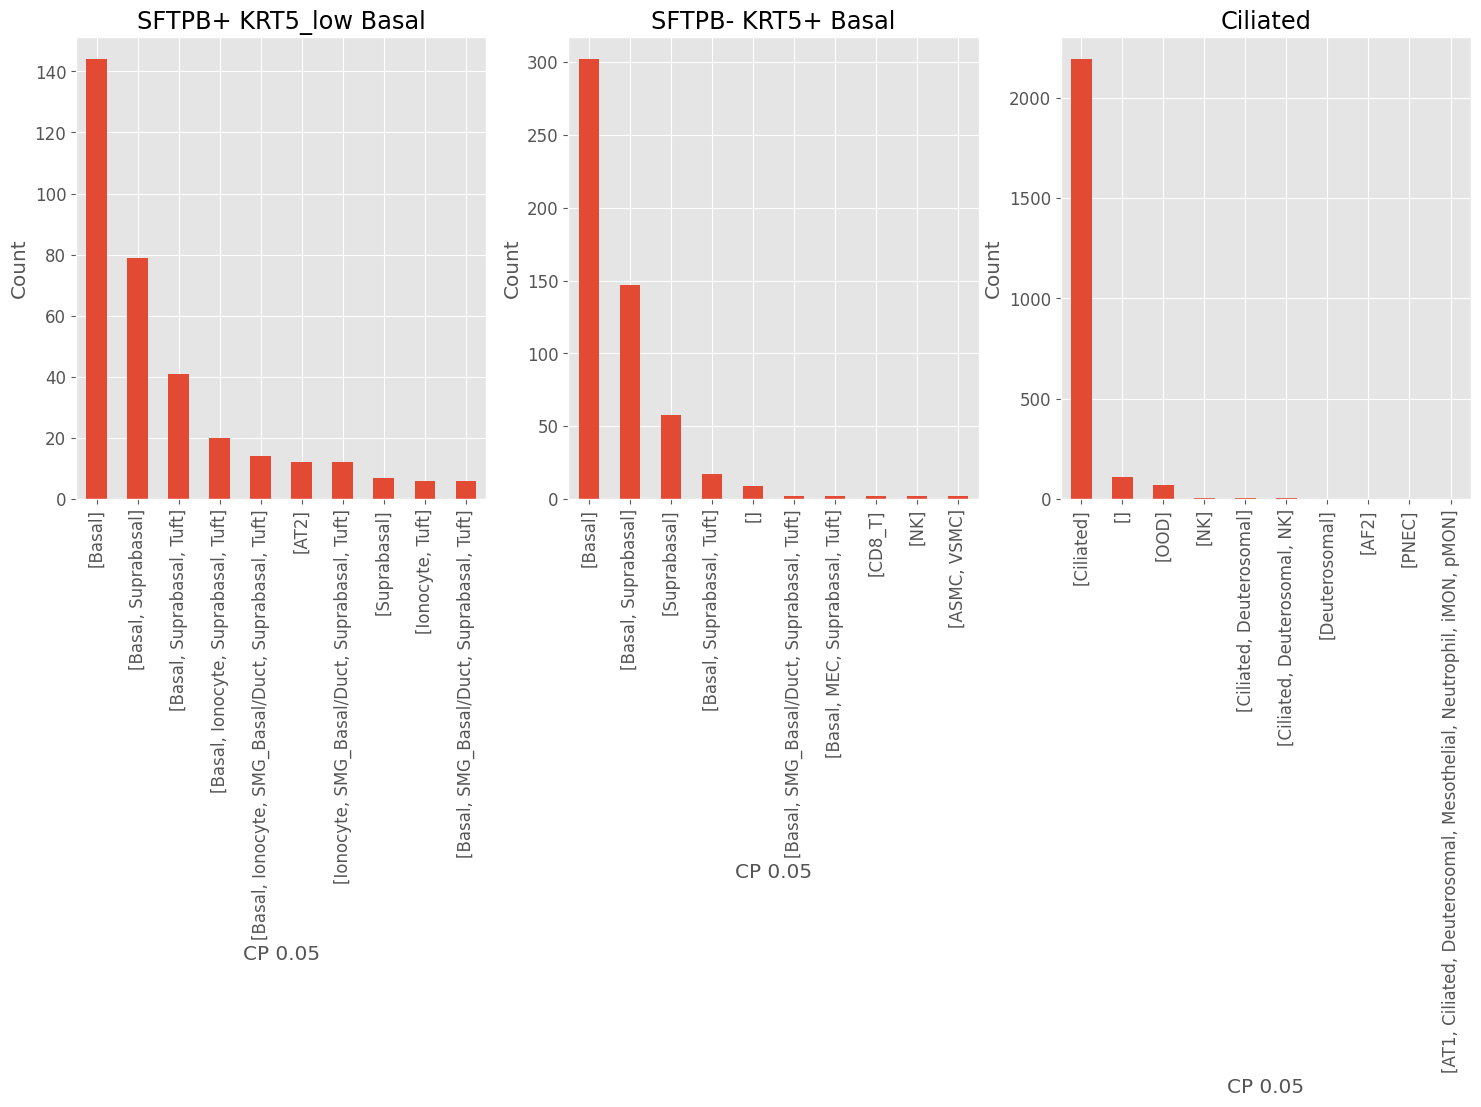

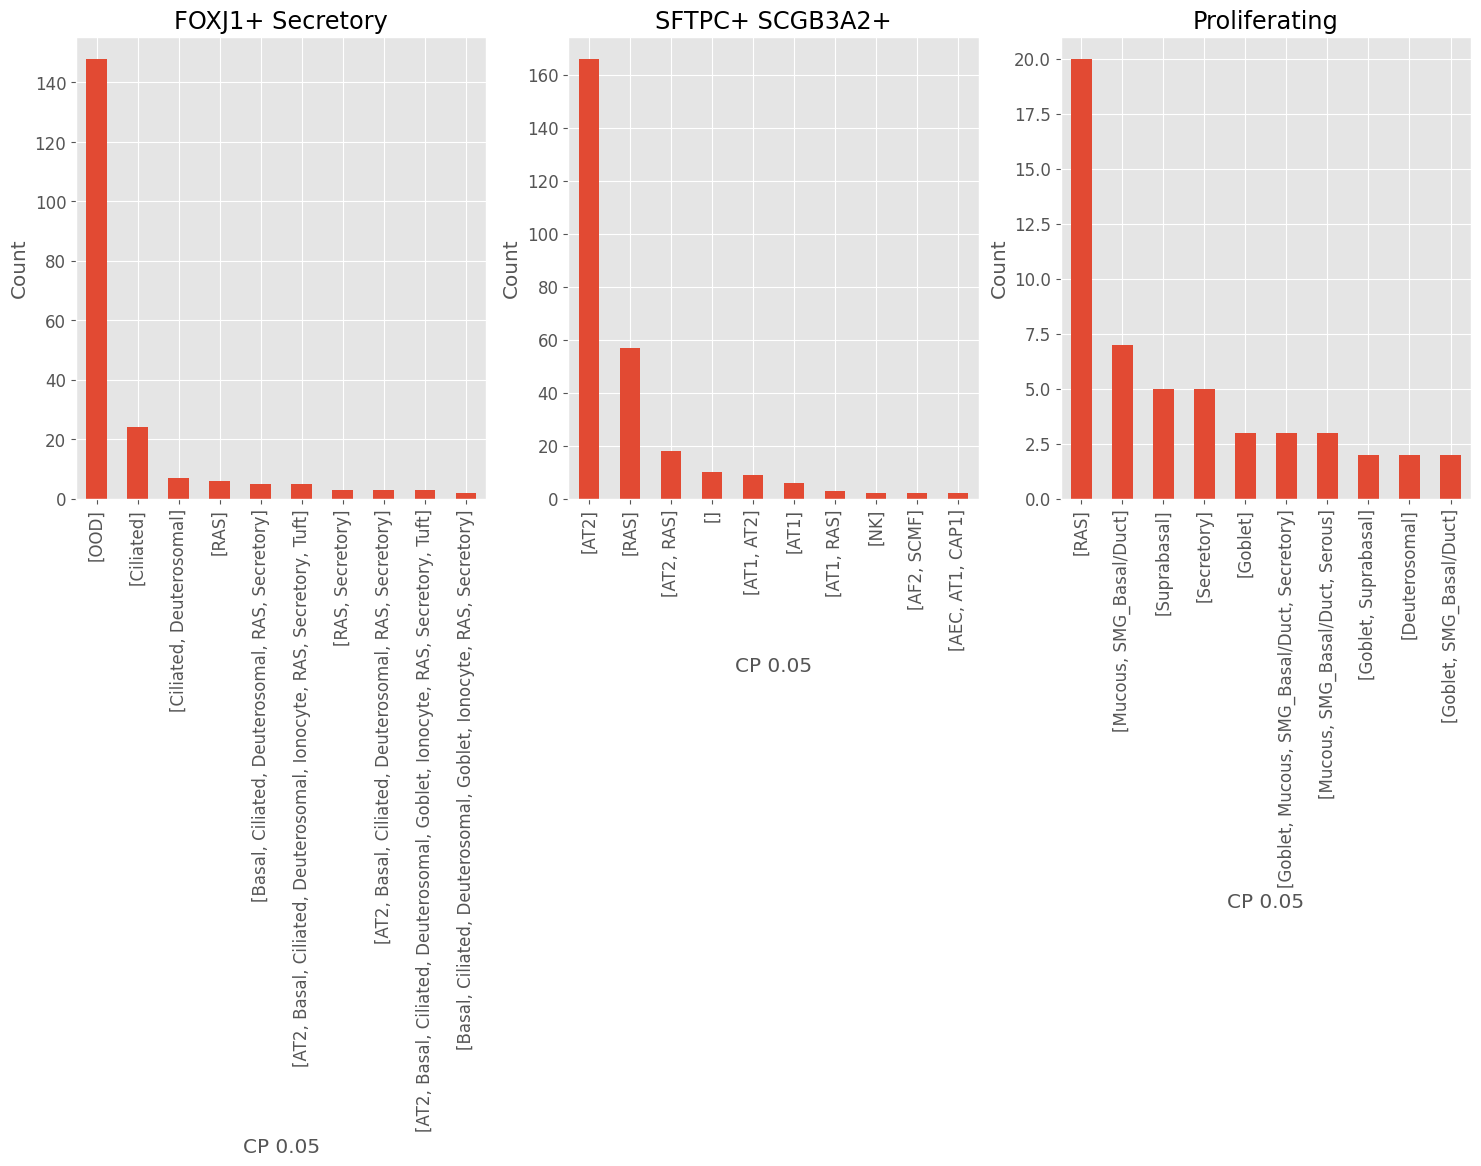

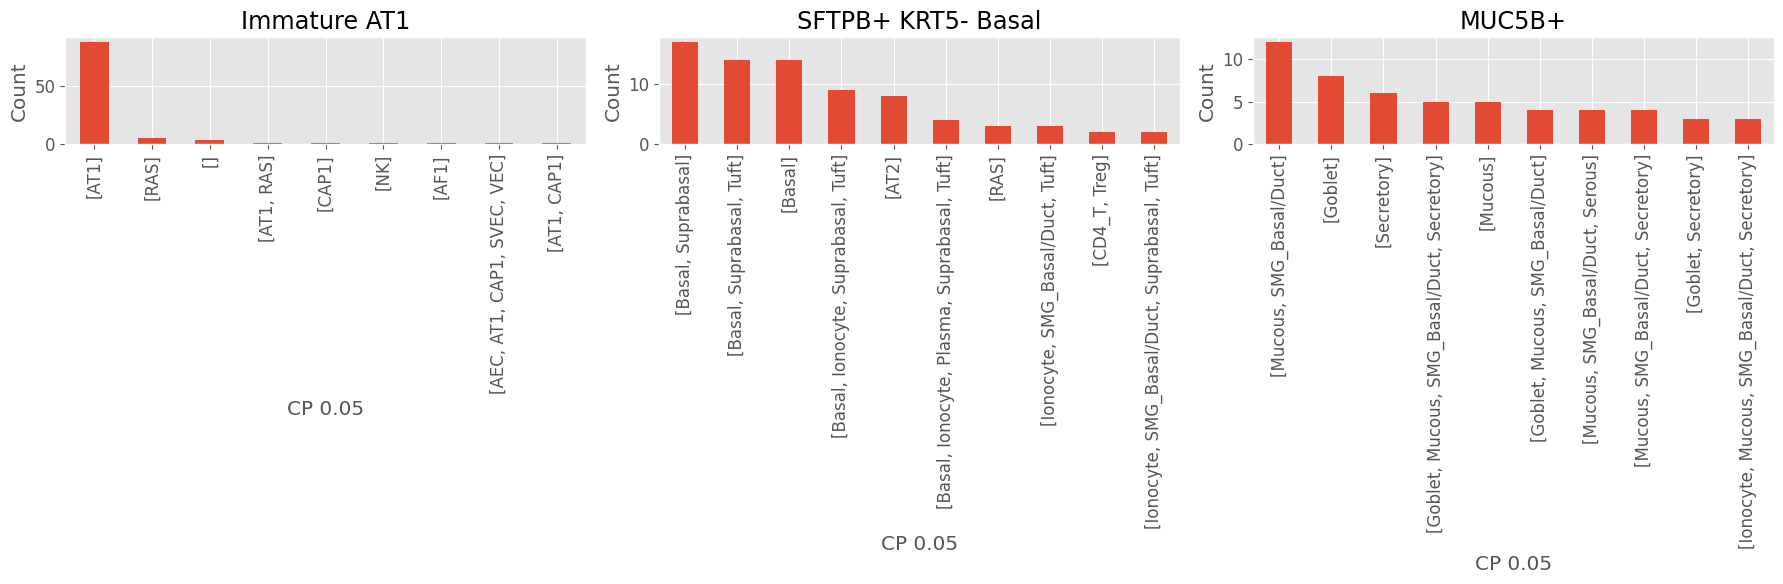

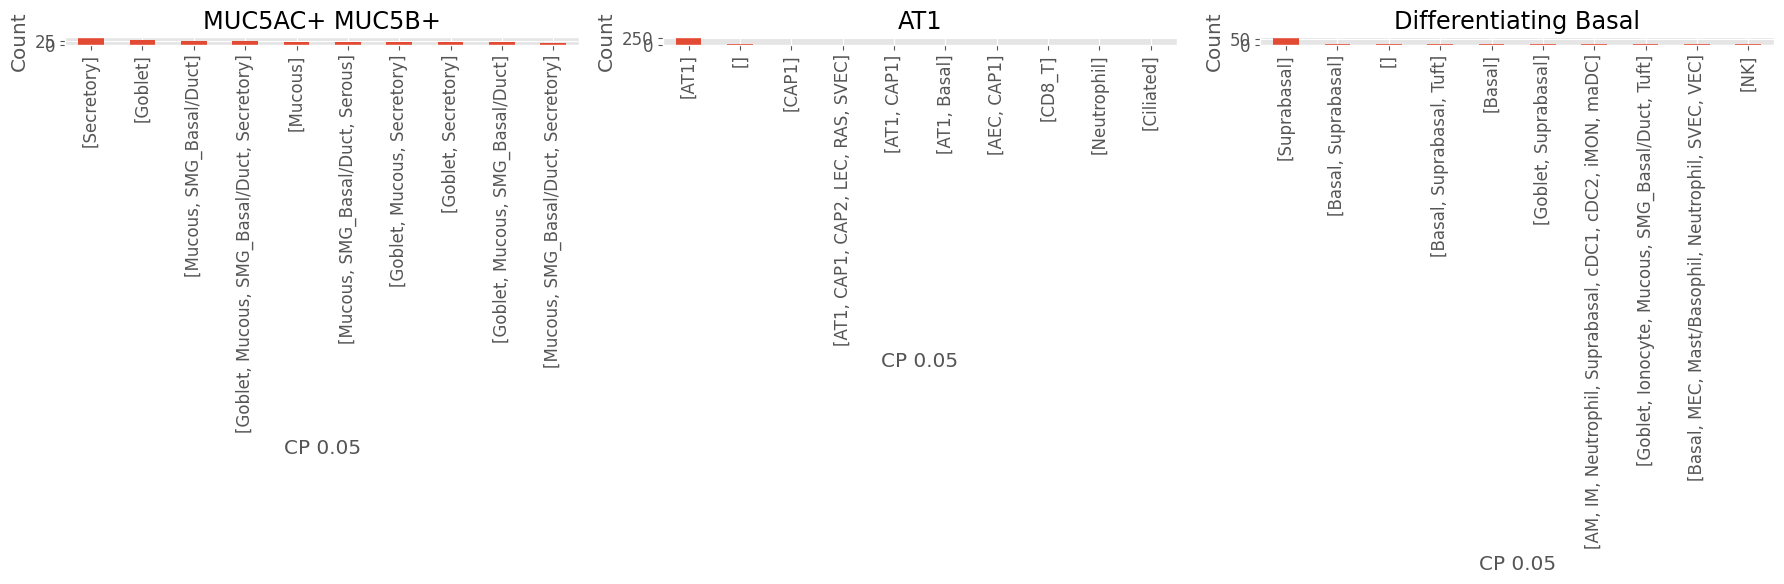

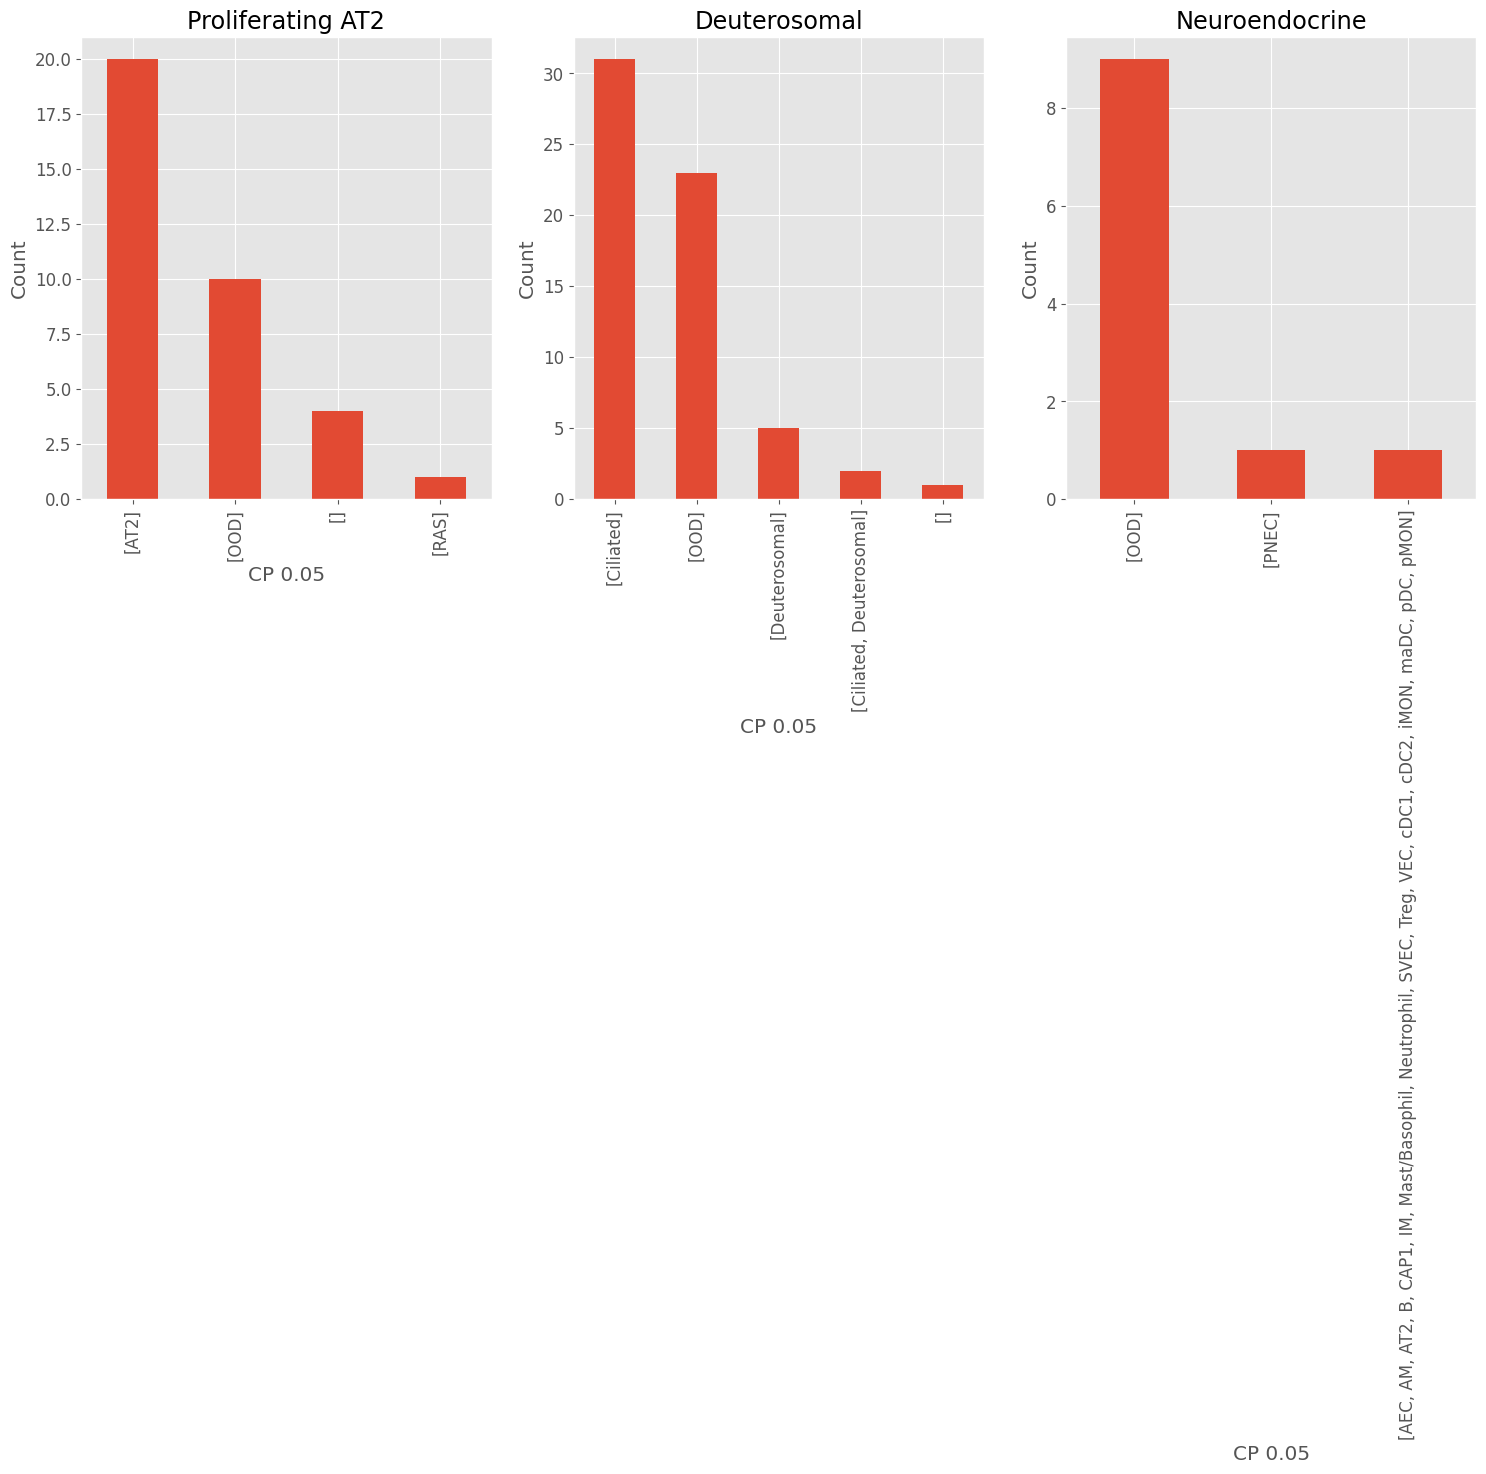

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set scientific style
plt.style.use('ggplot')
rcParams.update({'font.size': 12, 'figure.figsize': (12, 6)})

unique_cells = df_results['Original_Cell_Subtype'].unique()

# Create blocks of 3
block_size = 3
for i in range(0, len(unique_cells), block_size):
    fig, axes = plt.subplots(1, block_size, figsize=(18, 6))
    for j, cell in enumerate(unique_cells[i:i + block_size]):
        ax = axes[j] if block_size > 1 else axes
        df_ = df_results[df_results['Original_Cell_Subtype'] == cell]
        
        # Get the value counts and limit to the top 10 elements
        value_counts = df_["CP 0.05"].value_counts().head(10)
        
        # Plot on the corresponding subplot
        value_counts.plot(kind='bar', ax=ax)
        ax.set_title(cell)
        ax.set_xlabel('CP 0.05')
        ax.set_ylabel('Count')
        
    
    # Adjust layout
    plt.tight_layout()
    plt.show()